#**Deep learning based end-to-end speech recognition**

The goal of this project is to get familiar with applications that require speech data as input.

We would be using the torchaudio library (pip install torchaudio==0.11.0), please carefull read this tutorial https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

Next, we would ask you to perform similar analysis on a speech dataset, i.e., speechdata.zip. Unzip this folder, you would see a folder named wavs, and a file called "labels.csv", containing annotated transcripts, including the files in the wavs folder (you have more labels in labels.csv). This dataset is selected from https://keithito.com/LJ-Speech-Dataset/, a famous speech-based application benchmark.

General torchaudio tutorials: https://pytorch.org/tutorials/index.html
 


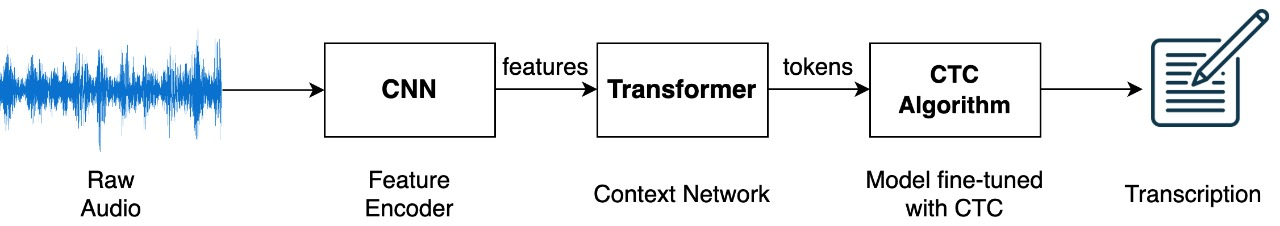

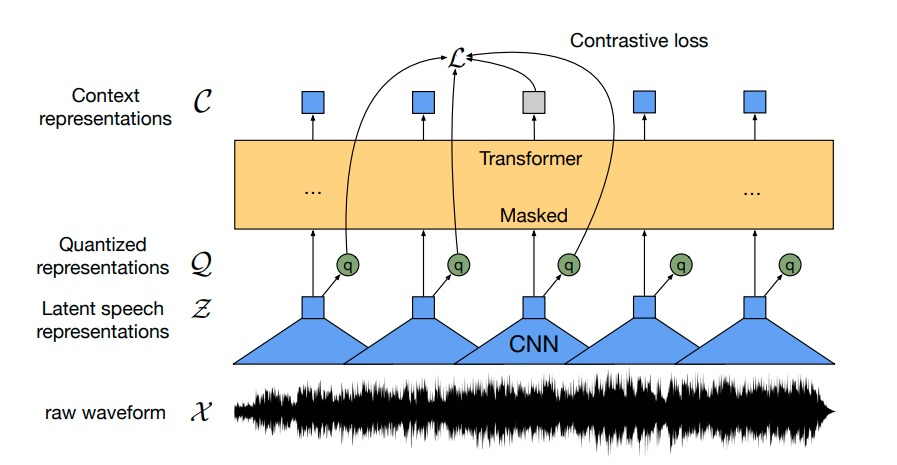

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Import libraries**

In [ ]:
# Import needed libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import IPython
import torch
import torchaudio
from scipy import signal
import os
from scipy.io import wavfile
import librosa.display

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


##**Import data**

In [ ]:
#link of records file
speech_urls='/content/drive/MyDrive/lab_5/wavs'
#link of one randomly sampled wav file
SPEECH_FILE= '/content/drive/MyDrive/lab_5/wavs/LJ001-0010.wav'

##**Creat the interface to instantiate model**

The bundle object provides the interface to instantiate model and other information. Sampling rate and the class labels are found as follow.

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically fetch the pre-trained weights and load it into the model.

In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
#display the model architecture
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (2): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (3): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (4): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
      (6): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjec

## **Task 1: Basic data exploration**
Select one randomly sampled wav file in the given folder, perform the following analysis:

1) Print the shape of the picked waveform

2) Print the sample rate of the waveform. 

3) Visualize the waveform using matplotlib

4) Create the spectrogram representation of the picked waveform and visualize it. 

5) Create the MFCC representation of the picked waveform and visualize it.

Reference: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook 

Displaying the randomly sampled wav file

In [ ]:
#display the randomly sampled wav file we select 
IPython.display.Audio(SPEECH_FILE)

To load data, we use **torchaudio.load()**.


In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

In [ ]:
#display the waveform 
waveform

tensor([[-0.0007, -0.0006, -0.0007,  ..., -0.0007, -0.0015, -0.0023]])

Print the shape of the picked waveform and its sample rate

In [ ]:
#Print the shape of the picked waveform
print("Shape of waveform: {}".format(waveform.size()))

#Print the sample rate of the waveform
print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 194461])
Sample rate of waveform: 22050


If the sampling rate is different from what the pipeline expects, then we can use **torchaudio.functional.resample()** for resampling.

In [ ]:
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

Print the shape of the picked waveform and its sample rate after resampling

In [ ]:
#Print the shape of the picked waveform after resampling
print("Shape of waveform: {}".format(waveform.size()))

#Print the sample rate of the waveform after resampling
print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 141106])
Sample rate of waveform: 22050


Visualize the waveform

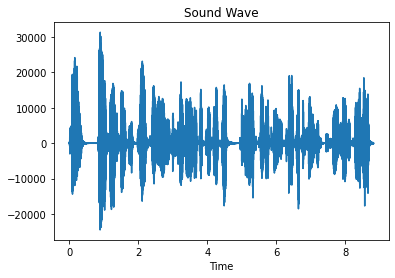

In [ ]:
import wave, sys

# function to display the sound waves
def visualize(path: str):

	# reading the selected audio file
	raw = wave.open(SPEECH_FILE)
	
	# reads all the frames (-1 indicates all or max frames)
	signal = raw.readframes(-1)
	signal = np.frombuffer(signal, dtype ="int16")
	
	# gets the frame rate
	f_rate = raw.getframerate()

	# to Plot the x-axis in seconds
	# you need to get the frame rate and divide by size of your signal
	# to create a Time Vector spaced linearly with the size of the audio file
	time = np.linspace(
		0, # start
		len(signal) / f_rate,
		num = len(signal)
	)

	# using matplotlib to plot
	# creates a new figure
	plt.figure(1)
	
	# title of the plot
	plt.title("Sound Wave")
	
	# label of x-axis
	plt.xlabel("Time")
	
	# actual plotting
	plt.plot(time, signal)
	
	# shows the plot in new window
	plt.show()

	# we can also save the plot using
	# plt.savefig('filename')


if __name__ == "__main__":

	# gets the command line Value
	path = sys.argv[1]

	visualize(path)


**Creating & visualizing the spectrogram representation of the picked waveform**

We can also display a spectrogram using **librosa.display.specshow**.

Visualizing data with a spectrogram helps reveal hidden insights in the audio data that may have been less apparent in the traditional waveform representations, allowing us to distinguish noise from the true audio data we wish to interpret. By visualizing audio data this way we can get a clear picture of the imperfections or underlying issues present, helping to guide our analysis and repair of the audio

In [ ]:
x , sr = librosa.load(SPEECH_FILE)

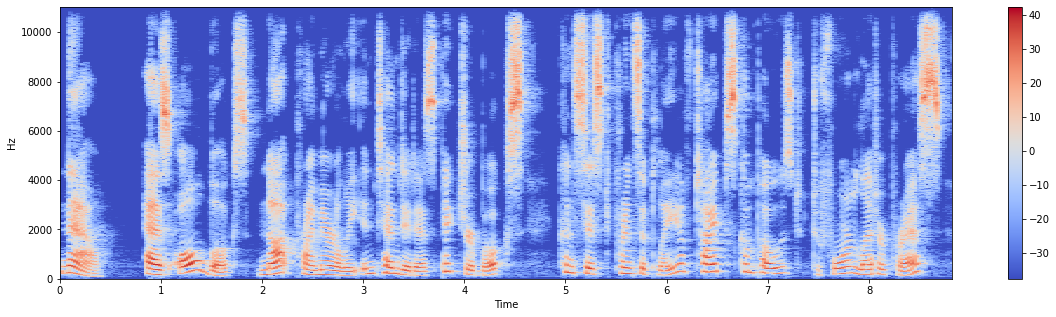

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

**Creating & visualizing the MFCC representation of the picked waveform**

Mel-Frequency Cepstral Coefficients (MFCC): It is the most widely used audio feature extraction technique. It is a representation of the short-term power spectrum of a sound. Mel-frequency cepstral — inverse Fourier transform of the logarithm of the estimated signal spectrum — coefficients are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip on the mel-scale.

(20, 380) 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


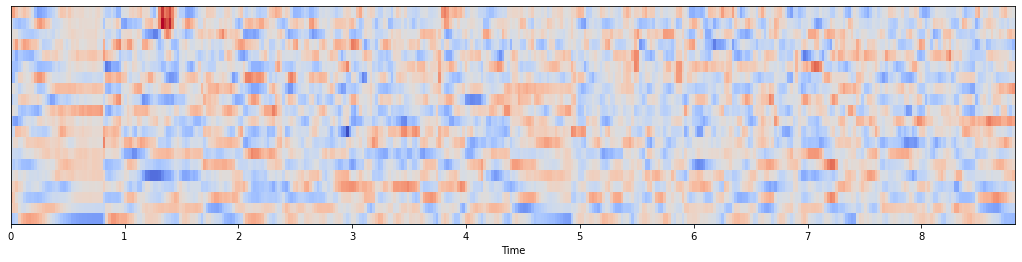

In [ ]:
plt.rcParams['figure.figsize'] = (18,4)

librosa.display.waveplot(x, sr)

mfccs = librosa.feature.mfcc(x, sr)
print(mfccs.shape,'\n')
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## **Task 2: Creating a Wav2Vec2 model that can perform feature extraction and classification**


In [ ]:
# Wav2vec2 https://towardsdatascience.com/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations-7d3728688cae 
# CTC Algorithm https://distill.pub/2017/ctc/

**Extracting acoustic features**

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of a transformer layer.

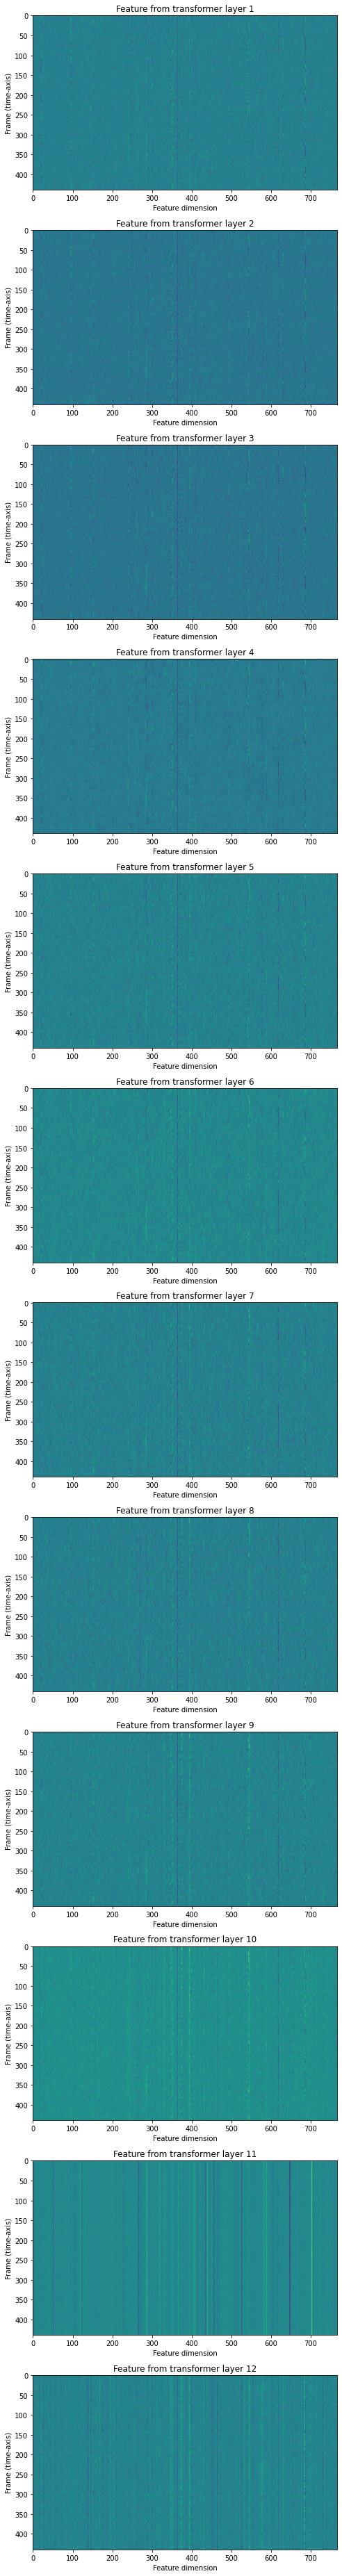

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

**Feature classification**

Once the acoustic features are extracted, the next step is to classify them into a set of categories.

Wav2Vec2 model provides method to perform the feature extraction and classification in one step with the following code 😀:

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
emission

tensor([[[14.8424, -1.2557, -1.1712,  ..., -8.1054, -8.7289, -8.1272],
         [15.0447, -0.5454, -1.3938,  ..., -8.0387, -8.6490, -7.6336],
         [14.6421, -0.0955, -1.0559,  ..., -8.1899, -8.2012, -7.1444],
         ...,
         [14.9286, -1.2978, -2.6482,  ..., -6.7300, -7.6143, -8.1936],
         [14.9275, -1.2996, -2.6460,  ..., -6.7314, -7.6148, -8.1941],
         [14.9879, -0.5352, -1.4119,  ..., -7.9942, -8.5290, -7.9057]]])

The output is in the form of logits. It is not in the form of probability.

Let’s visualize this.

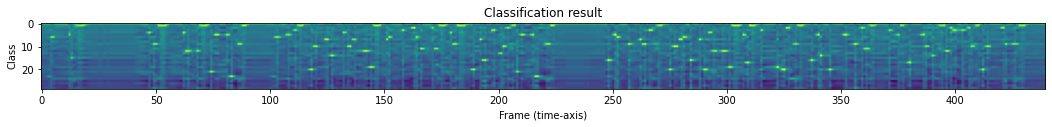

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()

print("Class labels:", bundle.get_labels())

We can see that there are strong indications to certain labels across the time line.

**Generating transcripts**

we will perform greedy decoding which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.

We start by defining greedy decoding algorithm.

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

Now create the decoder object and decode the transcript.

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

Let’s check the result and listen again to the audio.

In [ ]:
print(transcript.replace('|'," "))
IPython.display.Audio(SPEECH_FILE)

NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PICTURE BOOKS CONSIST PRINCIPALLY OF TYPES COMPOSED TO FORM LETTER PRESS 


**Generating general function**

We can improve the readability of the code by creating a function that combines the above steps from taking the audio link until providing its transcript as follows 💁🏻‍♀️: 

In [ ]:
#Function
def audio2text(SPEECH_FILE):
  """
  The main task of the function is to make speech recognition

  input: audio link
  output: audio transcript
  """
  waveform, sample_rate = torchaudio.load(SPEECH_FILE)
  waveform = waveform.to(device)

  if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

  with torch.inference_mode():
    emission, _ = model(waveform)

  decoder = GreedyCTCDecoder(labels=bundle.get_labels())
  transcript = decoder(emission[0])
  
  print(transcript.replace('|'," "))
  return transcript.replace('|'," ")

Let’s check the result and listen again to the audio after applying our function **audio2text**

In [ ]:
audio2text(SPEECH_FILE)
audio =IPython.display.Audio(SPEECH_FILE)

NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PICTURE BOOKS CONSIST PRINCIPALLY OF TYPES COMPOSED TO FORM LETTER PRESS 


## **Task 3: Extract acoustic features and generate predicted transcript for each waveform in the given dataset**

In [ ]:
# input: 100 file wavs 
# output: Array contains the 100 predicted transcript (hypothesis)

In [ ]:
audio_list = os.listdir(speech_urls)

#len of audio files (must be 100 files)
print("Length of audio files",len(audio_list))

#delete the last one(does not included to our list)
del audio_list[-1]

print("Length of audio files",len(audio_list))

Length of audio files 101
Length of audio files 100


In [ ]:
#sort the audio files list
audio_list= np.sort(audio_list)

In [ ]:
#print the sorted list of audio files (100 files)
audio_list

array(['LJ001-0001.wav', 'LJ001-0002.wav', 'LJ001-0003.wav',
       'LJ001-0004.wav', 'LJ001-0005.wav', 'LJ001-0006.wav',
       'LJ001-0007.wav', 'LJ001-0008.wav', 'LJ001-0009.wav',
       'LJ001-0010.wav', 'LJ001-0011.wav', 'LJ001-0012.wav',
       'LJ001-0013.wav', 'LJ001-0014.wav', 'LJ001-0015.wav',
       'LJ001-0016.wav', 'LJ001-0017.wav', 'LJ001-0018.wav',
       'LJ001-0019.wav', 'LJ001-0020.wav', 'LJ001-0021.wav',
       'LJ001-0022.wav', 'LJ001-0023.wav', 'LJ001-0024.wav',
       'LJ001-0025.wav', 'LJ001-0026.wav', 'LJ001-0027.wav',
       'LJ001-0028.wav', 'LJ001-0029.wav', 'LJ001-0030.wav',
       'LJ001-0031.wav', 'LJ001-0032.wav', 'LJ001-0033.wav',
       'LJ001-0034.wav', 'LJ001-0035.wav', 'LJ001-0036.wav',
       'LJ001-0037.wav', 'LJ001-0038.wav', 'LJ001-0039.wav',
       'LJ001-0040.wav', 'LJ001-0041.wav', 'LJ001-0042.wav',
       'LJ001-0043.wav', 'LJ001-0044.wav', 'LJ001-0045.wav',
       'LJ001-0046.wav', 'LJ001-0047.wav', 'LJ001-0048.wav',
       'LJ001-0049.wav',

In [ ]:
#apply the function to each audio file in the list
#then append the resulted transcript of each on in a list called: transcriptes
transcripts=[]
for audio in audio_list:
    aduio_link= os.path.join(speech_urls, audio)
    transcripts.append(audio2text(aduio_link))

PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION 
IN BEING COMPARATIVELY MODERN 
FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS 
PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK 
THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CENTURY MAY JUSTLY BE CONSIDERED AS THE INVENTION OF THE ART OF PRINTING 
AND IT IS WORTH MENTION IN PASSING THAT AS AN EXAMPLE OF FINE TYPOGRAPHY 
THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES THE GUTTENBERG OR FORTY TWO LINE BIBLE OF ABOUT FOURTEEN FIFTY FIVE 
HAS NEVER BEEN SURPASSED 
PRINTING THEN FOR OUR PURPOSE MAY BE CONSIDERED AS THE ART OF MAKING BOOKS BY MEANS OF MOVABLE TYPES 
NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PICTURE BOOKS CONSIST PRINCIPALLY OF TYPES COMPOSED TO FORM LETTER PR

In [ ]:
#print the length of resulted list 
#to make sure each file was preprocessed within the function
len(transcripts)

100

## **Task 4: evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)**

Hint: consider this package, https://pypi.org/project/jiwer/

**Word Error Rate (WER)** is a common metric for measuring speech-to-text accuracy of automatic speech recognition (ASR) systems, which is defined as the proportion of word errors to words processed. 

   * The best achievable WER score is 0, which means that every word is transcribed correctly.

**Match Error Rate (MER)** is the proportion of I/O word matches, which are errors, which means that is the probability of a given match being incorrect.

In [ ]:
# TODO code for task 4

#pre-processing using transformation API
   # LowerCase, RemoveWhiteSpace, RemovePunctuation, etc.

#dataframe (100, 5)
   # columns: (File_Name, Ground_Truth,	Hypothesis, WER, MER) 

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.7 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=04f055a3947cba0e1319df7d6d9c5ab9a25d980f9d1f2ec4f1fcc65679e28398
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
#read labels csv file
labels_url='/content/drive/MyDrive/lab_5/labels.csv'
labels= pd.read_csv(labels_url,header=None,sep='|',engine='python', error_bad_lines=False)
labels.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,"in being comparatively modern.,,,,,,,,,,,,,,,,,,,"
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


As we see, the file contains the file name of each audio, the origional transcript, the normalized transcript.

In [ ]:
#shape of labels file
labels.shape

(523, 3)

In [ ]:
#create new dataframe that contains the first two columns only from the origional labels file
#we will deal with the origional text only (second column)
df= labels.iloc[0:100,0:2]
df.head()

,0,1
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...


In [ ]:
#display the head of new dataframe
df.shape

(100, 2)

In [ ]:
#rename dataframe columns
df.rename(columns = {0:'File_Name', 1:'Ground_Truth'}, inplace = True)

In [ ]:
#add the hypothesis columnto the dataframe (the resulted transcriptes from the previous task)
df['Hypothesis']= transcripts

In [ ]:
#display the head of new dataframe
df.head()

,File_Name,Ground_Truth,Hypothesis
0,LJ001-0001,"Printing, in the only sense with which we are ...",PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...
1,LJ001-0002,in being comparatively modern.,IN BEING COMPARATIVELY MODERN
2,LJ001-0003,For although the Chinese took impressions from...,FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...
3,LJ001-0004,"produced the block books, which were the immed...",PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...
4,LJ001-0005,the invention of movable metal letters in the ...,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...


In [ ]:
import jiwer

ground_truth = list(df['Ground_Truth']) #origional text
hypothesis = transcripts                # predicted text

#identify the transformation that will be applied on both texts
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),                                #used to convert every character into lowercase.
    jiwer.RemoveWhiteSpace(replace_by_space=True),      #used to filter out white space.
    jiwer.RemoveMultipleSpaces(),                       #used to filter out multiple spaces between words
    jiwer.RemoveEmptyStrings(),                         #used to remove empty strings.
    jiwer.RemovePunctuation(),                          #used to filter out punctuation
    jiwer.ExpandCommonEnglishContractions(),            #used to replace common contractions such as 're to are.
    jiwer.ReduceToListOfListOfWords(word_delimiter=" ") # used to transform one or more sentences into a list of lists of words. 
]) 

In [ ]:
#Word Error Rate (WER) for each origional text compared to the predicted one
WER=[]
for i in range(len(df)):
  wer= jiwer.wer(
      ground_truth[i], 
      hypothesis[i], 
      truth_transform=transformation, 
      hypothesis_transform=transformation
  )
  WER.append(wer)

In [ ]:
#Match Error Rate (MER) for each origional text compared to the predicted one
MER=[]
for i in range(len(df)):
  mer= jiwer.mer(
    ground_truth, 
    hypothesis, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
  )
  MER.append(mer)

In [ ]:
#add the two columns to our dataframe
df['WER']= WER
df['MER']= MER

In [ ]:
#display the head of new dataframe
df.head()

,File_Name,Ground_Truth,Hypothesis,WER,MER
0,LJ001-0001,"Printing, in the only sense with which we are ...",PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...,0.000000,0.071181
1,LJ001-0002,in being comparatively modern.,IN BEING COMPARATIVELY MODERN,0.000000,0.071181
2,LJ001-0003,For although the Chinese took impressions from...,FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...,0.083333,0.071181
3,LJ001-0004,"produced the block books, which were the immed...",PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...,0.000000,0.071181
4,LJ001-0005,the invention of movable metal letters in the ...,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...,0.000000,0.071181


## **Task 5: check files with the worst performance and perform a simple error analysis, For example:** 
* what are the files having worser performance?
* what are the potential reasons?
* Do they share any common patterns?


*Speech recognition model isn't always able to interpret spoken words correctly. This is due to computers not being on par with humans in understanding the contextual relation of words and sentences, causing misinterpretations of what the speaker meant to say or achieve.*

###**Regarding to WER**

In [ ]:
#display the index of first occurrence of maximum in 'WER' column
df.loc[df['WER'].idxmax()]

File_Name                                  LJ001-0045
Ground_Truth                              1469, 1470;
Hypothesis      FOURTEEN SIXTY NINE FOURTEEN SEVENTY 
WER                                               2.5
MER                                          0.071181
Name: 44, dtype: object

**Observation:** The file with name  'LJ001-0045' has the worst value of WER which is 2.5

In [ ]:
#display the records that has WER value greater than or equals to .4
df.loc[df['WER']>=.4]

,File_Name,Ground_Truth,Hypothesis,WER,MER
44,LJ001-0045,"1469, 1470;",FOURTEEN SIXTY NINE FOURTEEN SEVENTY,2.5,0.071181


**Observation:** From the code cell above, we knew that there are now files contain WER value between .4 & 2.5 except one that have index (44).

In [ ]:
#display the records that has WER value greater than or equals to .3
df.loc[df['WER']>=.3]

,File_Name,Ground_Truth,Hypothesis,WER,MER
6,LJ001-0007,"the earliest book printed with movable types, ...",THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES T...,0.375000,0.071181
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS ...,0.357143,0.071181
44,LJ001-0045,"1469, 1470;",FOURTEEN SIXTY NINE FOURTEEN SEVENTY,2.500000,0.071181
80,LJ001-0081,type cast from his matrices is still in everyd...,TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY...,0.300000,0.071181
91,LJ001-0092,The Chiswick press in 1844 revived Caslon's fo...,THE CHISWICK PRESS IN EIGHTEEN FORTY FOUR REVI...,0.352941,0.071181


**Observation:** The above 5 files have the worst value of WER for our data.

Check these 5 files to check the potential reasons & to find if they share any common patterns.

In [ ]:
#create a list of file indexes that share the worst WER value
indexes=[6,30,44,80,91] 

for i in range(len(indexes)):
  index=indexes[i]
  print("The Ground_Truth & Hypothesis of the file with index ",index," is:")
  print("The Ground_Truth text is: ", df.iloc[index,:]['Ground_Truth'])
  print("The Hypothesis text is: ", df.iloc[index,:]['Hypothesis'])
  print('\n')

The Ground_Truth & Hypothesis of the file with index  6  is:
The Ground_Truth text is:  the earliest book printed with movable types, the Gutenberg," or ""forty-two line Bible"" of about 1455",
The Hypothesis text is:  THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES THE GUTTENBERG OR FORTY TWO LINE BIBLE OF ABOUT FOURTEEN FIFTY FIVE 


The Ground_Truth & Hypothesis of the file with index  30  is:
The Ground_Truth text is:  In 1465 Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,
The Hypothesis text is:  IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS BEGAN PRINTING IN THE MONASTERY OF SUBIACO NEAR ROME 


The Ground_Truth & Hypothesis of the file with index  44  is:
The Ground_Truth text is:  1469, 1470;
The Hypothesis text is:  FOURTEEN SIXTY NINE FOURTEEN SEVENTY 


The Ground_Truth & Hypothesis of the file with index  80  is:
The Ground_Truth text is:  type cast from his matrices is still in everyday use.
The Hypothesis text is:  TYPE CAST FROM HIS MATRESSES I

**Observation:** From our analysis, we observed that the above files has the worst value of WER because they contain numbers. The origional text contain the number in a numerical format but the expected text predect them as an alphabet format.

**Observation:** The file with index (80) shared another reason for getting WER value. the origional text say **'everyday'** that is an adjective we use to describe something that's seen or used every day. But the predected text provided it as **'every day'** that is a phrase that simply means “each day.”. It presented it by mistake because they have the same pronunciation so it seems that it predects always the compound words as separate words.

###**Regarding to MER**

In [ ]:
#display the index of first occurrence of maximum in 'MER' column
df.loc[df['MER'].idxmax()]

File_Name                                              LJ001-0001
Ground_Truth    Printing, in the only sense with which we are ...
Hypothesis      PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...
WER                                                           0.0
MER                                                      0.071181
Name: 0, dtype: object

**Observation:** The file with name  'LJ001-0001' has the worst value of MER which is 0.071181

In [ ]:
#display the records that has MER value greater than or equals to 0.07118
df.loc[df['MER']>=0.07118]

,File_Name,Ground_Truth,Hypothesis,WER,MER
0,LJ001-0001,"Printing, in the only sense with which we are ...",PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...,0.000000,0.071181
1,LJ001-0002,in being comparatively modern.,IN BEING COMPARATIVELY MODERN,0.000000,0.071181
2,LJ001-0003,For although the Chinese took impressions from...,FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...,0.083333,0.071181
3,LJ001-0004,"produced the block books, which were the immed...",PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...,0.000000,0.071181
4,LJ001-0005,the invention of movable metal letters in the ...,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...,0.000000,0.071181
...,...,...,...,...,...
95,LJ001-0096,have now come into general use and are obvious...,HAVE NOW COME INTO GENERAL USE AND ARE OBVIOUS...,0.000000,0.071181
96,LJ001-0097,a little reduced in ugliness. The design of th...,A LITTLE REDUCED IN UGLINESS THE DESIGN OF THE...,0.000000,0.071181
97,LJ001-0098,"and the whole effect is a little too gray, owi...",AND THE WHOLE EFFECT IS A LITTLE TOO GREY OWIN...,0.062500,0.071181
98,LJ001-0099,"It must be remembered, however, that most mode...",IT MUST BE REMEMBERED HOWEVER THAT MOST MODERN...,0.000000,0.071181


**Observation:** We observed that, all the 100 file share the same value of MER which is .071181